In [126]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import os #truy cập file
import numpy as np
import pandas as pd
from tensorflow import keras as k
from keras.utils import np_utils
import cv2 #xử lý ảnh
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense

X=[]
y=[]

for dirname, _, filenames in os.walk('/content/capcha'):
    for filename in filenames:
        path=os.path.join(dirname, filename) #nối đường dẫn từng file 
#Tiền xử lý ảnh:
#đọc ảnh
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #hình ảnh captcha thang độ xám đại diện cho chuỗi số từ 0 đến 255 (dang 8 bit)

# Adaptive Threshold: Ngưỡng thích ứng đối với mỗi pixel là 145
# Biến đổi thang độ xám -> nhị phân: Nếu gtri pixel < ngưỡng thì đặt nó là 0; ngược lại đặt là maxValue = 255
        image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

#Biến đổi hình thái nâng cao
#đọc thêm: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
#MORPH_CLOSE:Nó rất hữu ích trong việc đóng các lỗ nhỏ bên trong các đối tượng tiền cảnh, hoặc các điểm đen nhỏ trên đối tượng.
        kernel = np.ones((5,5),np.uint8) #ma trận (5,5) dạng 8 bit
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        
# - Dilation: tăng vùng trắng/ kích thước của ảnh
        kernel = np.ones((2,2),np.uint8) #ma trận (2,2) dạng 8 bit
        image = cv2.dilate(image, kernel, iterations = 1)
 
# Làm mờ: Như trong tín hiệu một chiều, hình ảnh cũng có thể được lọc bằng nhiều bộ lọc thông thấp (LPF), bộ lọc thông cao (HPF), v.v.
# LPF giúp loại bỏ nhiễu, làm mờ hình ảnh, v.v. Bộ lọc HPF giúp tìm kiếm các cạnh trong hình ảnh.
        image = cv2.GaussianBlur(image, (5,5), 0)
 
# Chia hình ảnh thành các phần của mỗi kí tự (ở đây có 5 kí tự tương ứng với 5 phân đoạn)
        x=[image[10:50,30:50],image[10:50,50:70],
                 image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]
        #ví dụ với ảnh "226md.png" -> image[10:50, 30:50]: kí tự 1: hàng từ 10 đến 49 ta lấy cột từ 30 đến 49 thì được số 2
# gán nhãn các phân đoạn bằng tên hình ảnh
        for i in range(5):
            X.append(img_to_array(Image.fromarray(x[i]))) #lấy từng phân đoạn tạo thành một array
            #Image.fromarray: lưu ảnh dưới dạng thang độ xám từ 0 -> 255
            y.append(path[len(path)-9:len(path)-4][i]) #lấy tên nhãn từ đường dẫn từ cuối lên (ví dụ 226md.png -> y ="226md")
X=np.array(X)
y=np.array(y)
#print(X)

Chia tỷ lệ các giá trị X, Mã hóa các nhãn

In [127]:
X=X.astype('float32') 
X/=255

y_le = LabelEncoder().fit_transform(y)
#LableEncoder: Mã hóa nhãn đích y có giá trị từ 0 đến n_classes-1, 
#fit_transform: Điều chỉnh bộ mã hóa nhãn và trả về các nhãn đã mã hóa.

y_ohe = OneHotEncoder(sparse = False).fit_transform(y_le.reshape(len(y_le),1))
#OneHotEncoder: Mã hóa các tính năng phân loại dưới dạng một mảng số nóng.
#sparse: False: trả về mảng, True: trả về ma trận số

X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.2, random_state = 42)

row, col = X.shape[1],X.shape[2]
categories = y_ohe.shape[1]

info = {y_le[i] : y[i] for i in range(len(y))}

Model CNN

In [128]:
model = Sequential()

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same', input_shape=(row,col,1)))
model.add(Activation('relu')) #relu: f(x)= max(0, x)
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500)) #fullyconnected
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax")) #hàm softmax: (0;1]

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam' ,
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 activation (Activation)     (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 16)        2320      
                                                                 
 activation_1 (Activation)   (None, 20, 10, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 5, 16)        0         
 2D)                                                    

fitting and training

In [130]:
batch_size = 150
epochs = 200

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)

model.save('model.h5')

Epoch 1/200
29/29 [==============================] - 3s 99ms/step - loss: 0.3230 - accuracy: 0.8888 - val_loss: 0.4969 - val_accuracy: 0.8692
Epoch 2/200
29/29 [==============================] - 3s 98ms/step - loss: 0.3140 - accuracy: 0.8986 - val_loss: 0.5048 - val_accuracy: 0.8645
Epoch 3/200
29/29 [==============================] - 3s 99ms/step - loss: 0.3265 - accuracy: 0.8914 - val_loss: 0.4978 - val_accuracy: 0.8729
Epoch 4/200
29/29 [==============================] - 3s 98ms/step - loss: 0.3037 - accuracy: 0.8930 - val_loss: 0.4941 - val_accuracy: 0.8710
Epoch 5/200
29/29 [==============================] - 3s 98ms/step - loss: 0.3061 - accuracy: 0.8984 - val_loss: 0.5107 - val_accuracy: 0.8729
Epoch 6/200
29/29 [==============================] - 3s 98ms/step - loss: 0.2991 - accuracy: 0.8949 - val_loss: 0.5100 - val_accuracy: 0.8645
Epoch 7/200
29/29 [==============================] - 3s 97ms/step - loss: 0.3075 - accuracy: 0.8921 - val_loss: 0.5082 - val_accuracy: 0.8701
Epoch 

Predict

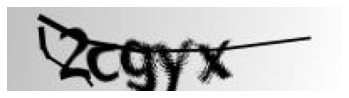

[ 0  8 12 18 17]
Prediction: 2cgyx
Actual:     2cgyx


In [156]:
from keras.models import load_model
model = load_model('model.h5')

def pred (img_path) :
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    image = cv2.GaussianBlur(image, (5,5), 0)
    #plt.imshow(image)
    
    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]
    
    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))
    
    X_pred = np.array(X_pred)
    X_pred/= 255.0

    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1) #trả về chỉ số của phần tử Max của mảng theo axis = 1 (trục Ox)
    print(y_pred)
    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')
        
    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])
pred('/content/2cgyx.png')